In [10]:
using Plots
using OptimalApplication

  3.664580 seconds (15.63 M allocations: 1.406 GiB, 6.28% gc time, 33.03% compilation time)


# The optimal college application strategy

## Exact algorithm for Alma's problem, implemented on binary heap

Alma's problem: $$\max\bigl\lbrace \operatorname{E}[\max\lbrace t_j Z_j: j \in \mathcal{X}\rbrace] : |\mathcal{X}| \leq h\bigr\rbrace$$

where $Z_j$ are independent Bernoulli with probabilities $f_j$. 

Solve an instance by enumeration, check that the results agree with the fast algorithm, produce a series of plots showing the nestedness property.

In [11]:
function plotsmaker()
    m = length(t)
    
    pl = [plot(
            xlabel="f",
            ylabel="t",
            size=(700, 700)
            ) for i in 1:m+2]
    
    x = zeros(Bool, m, m)
    
    scatter!(pl[1], f, t, c=:darkslategray, ms=11, msw=0, msa=0, legend=nothing)
    
    for i in 1:m
        x[optimalportfolio_enumerate(f, t, i), i] .= true
        
        scatter!(pl[i+1], f[.!x[:, i]], t[.!x[:, i]], c=:darkslategray, ms=11, msw=0, msa=0, label=nothing)
        scatter!(pl[i+1], f[x[:, i]], t[x[:, i]], c=:orangered, ms=11, msw=0, msa=0, label="apply when h = $i")
    end
    
    apporder = sortperm(reshape(sum(x, dims=2), :), rev=true)
    
    scatter!(pl[end], f, t, c=:forestgreen, ms=13, msw=0, msa=0, legend=nothing)
    annotate!(pl[end], [(f[i], t[i], text("$(apporder[i])", 9, :white)) for i in 1:m])
    
    return pl, x, apporder
end

plotsmaker (generic function with 1 method)

In [12]:
m = 20

φ = 0.7
t = rand(m) |> sort
f = 1 .- (φ*t + (1-φ)*rand(m))

@time pl, x, apporder = plotsmaker()
v_enum = [valuation(apporder[1:h], f, t) for h in 1:m]

for c in eachcol(x)
    println(c)
end

# for p in pl
#     display(p)
# end

[apporder v_enum applicationorder(f, t; datastructure=:dict)...]

UndefVarError: UndefVarError: valuation not defined

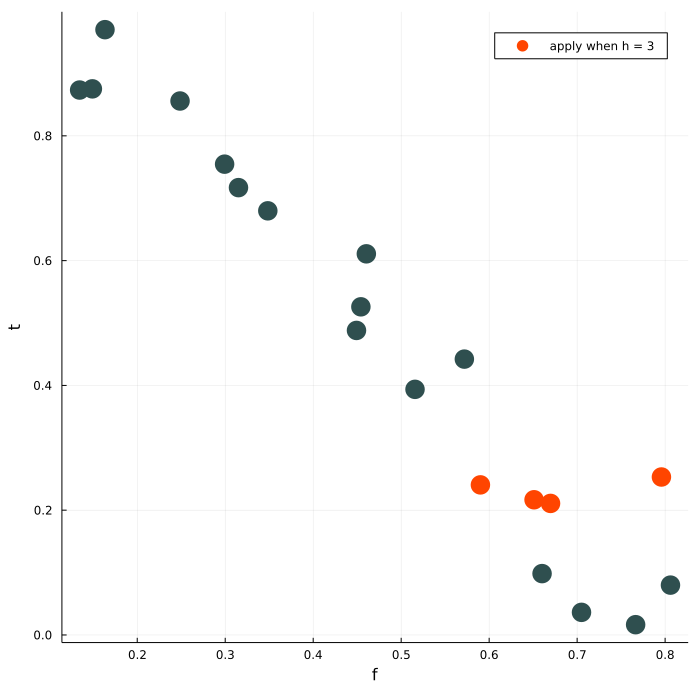

In [74]:
# for (n, i) in enumerate(pl)
#       display(i)
# end
display(pl[4])

In [47]:
# for (n, i) in enumerate(pl)
#     savefig(i, "optportfolio-$(n-1).png")
#     savefig(i, "optportfolio-$(n-1).pdf")
# end

In [3]:
# Helper for making my seminar slides
# for i in 0:length(pl)-1
#     print("\\begin{frame}\\begin{center}\\includegraphics[height=\\textheight]{./plots/optportfolio-$i.pdf}\\end{center}\\end{frame}\n")
# end

### Comparative statics example

In [21]:
t = Float64.(collect(range(start=200, step=50, length=8)))
f = [0.39, 0.33, 0.24, 0.24, 0.05, 0.03, 0.1, 0.12]

8-element Vector{Float64}:
 0.39
 0.33
 0.24
 0.24
 0.05
 0.03
 0.1
 0.12

In [22]:
apporder, v = applicationorder(f, t)
# v = [valuation(apporder[1:i], f, t) for i in 1:8]

[t f apporder round.(v)[apporder]]

8×4 Matrix{Float64}:
 200.0  0.39  4.0  230.0
 250.0  0.33  2.0  147.0
 300.0  0.24  8.0  294.0
 350.0  0.24  1.0   84.0
 400.0  0.05  7.0  289.0
 450.0  0.03  3.0  195.0
 500.0  0.1   5.0  258.0
 550.0  0.12  6.0  282.0

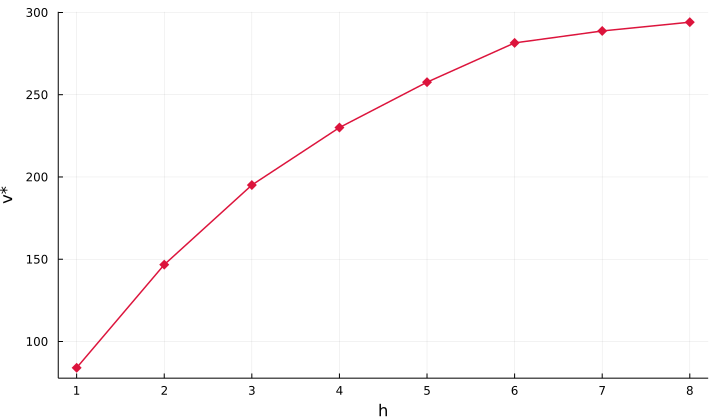

In [23]:
pl = plot(v, legend=false, size=(720, 420), xlabel="h", ylabel="v*", lw=1.5, color=:crimson, xticks=1:8, marker=:diamond, msw=0, msa=0, ms=5)

In [41]:
# savefig(pl, "h-utility.png")
# savefig(pl, "h-utility.pdf")

In [ ]:
Slightly nicer formatting of print above:

 200  0.39  4  230
 250  0.33  2  147
 300  0.24  6  282
 350  0.24  1   84
 400  0.05  7  289
 450  0.03  8  294
 500  0.1   5  258
 550  0.12  3  195

### Tight example

Tight example for bound $v(\mathcal{Y}) \geq v(\mathcal{X}) /h$, where $\mathcal{Y}$ is the naive solution that picks the $h$ schools with highest $f_j t_j$-value.

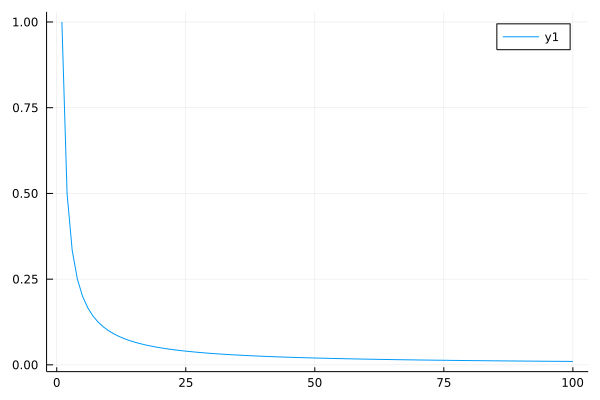

In [9]:
h = 100
m = 2 * h

f = vcat(ones(h), 2.0 .^ range(-1, step=-1, length=m))
t = 1 ./ f # (1 .+ range(0.000001, 0, length=m)) ./ f
ft = f .* t

X, V = applicationorder(f, t, h)
[valuation(collect(1:j), f, t)/V[j] for j in 1:h] |> plot

## Quasipolynomial-time algorithm for generalization with variable application costs

Ellis's problem: Now $g_j$ is the cost of applying to college $c_j$; $H$ is the total application budget. The problem is
$$\max\Bigl\lbrace \operatorname{E}[\max\lbrace t_j Z_j: j \in \mathcal{X}\rbrace] : \sum_{j \in \mathcal{X}} g_j \leq H\Bigr\rbrace$$

Let $V[j, h]$ denote the optimal portfolio costing no more than $h$ using only the first $j$ schools. 

Base cases:
$$
\begin{align*}
V[j, 0] &= 0, \quad & j = 0\dots m \\
V[0, h] &= -\infty, \quad & h < 0 \\
\end{align*}
$$

Bellman equation:
$$
\begin{align*}
V[j, h] &= \max\bigl( V[j-1, h],~(1 - f_j) V[j-1, h-g_j] + f_j t_j \bigr), \quad & j = 1\dots m, h = 1\dots H
\end{align*}
$$

In [122]:
"""
    valuationtable(f, t, g, H)

Given admissions probabilities `f`, utility values `t`, application costs `g`, and
budget `H`, uses a dynamic program to produce the optimal portfolio `X` and associated
valuation table `V`.
"""
function valuationtable(
        f::Vector{Float64},
        t::Vector{Float64},
        g::Vector{Int64},
        H=nothing::Union{Int64, Nothing})
    m = length(f)
    @assert m == length(t) == length(g)
    @assert issorted(t)
    if isnothing(H)
        H = sum(g)
    else
        @assert 0 < H
    end
    
    V = zeros(m, H)
#     U = falses(m, H)
    for j in 1:m, h in 1:H
        if h < g[j]
            V[j, h] = get(V, (j-1, h), 0)
        else
            V[j, h] = max(
                get(V, (j-1, h), 0),
                (1 - f[j])*get(V, (j-1, h - g[j]), 0) + f[j] * t[j]
            )
        end
    end
    
    h = H
    X = Int64[]
    for j in m:-1:1
        if get(V, (j-1, h), 0) <  get(V, (j, h), 0)
            push!(X, j)
            h -= g[j]
        end
    end

    return X, V
end


"""
    optimalportfolio_variablecosts(f, t, g, H)

Given admissions probabilities `f`, utility values `t`, application costs `g`, and
budget `H`, uses a dynamic program to produce the optimal portfolio `X` and associated
value `v`.
"""
function optimalportfolio_variablecosts(
        f::Vector{Float64},
        t::Vector{<:Real},
        g::Vector{Int64},
        H::Int64,
        memoize=true)
    m = length(f)
    @assert m == length(t) == length(g)
    @assert issorted(t)
    @assert 0 < H
    
    if memoize
        V_dict = Dict{Tuple{Int64, Int64}, Float64}()
    end
    
    function V(j, h)
        if memoize && haskey(V_dict, (j, h))
            return V_dict[(j, h)]
        end
        
        if j == 0 || h == 0
            return 0.0
        elseif h < g[j]
            if memoize
                push!(V_dict, (j, h)=>V(j-1, h))
                return V_dict[(j, h)]
            else
                return V(j-1, h)
            end
        else
            if memoize
                push!(V_dict, (j, h)=>max(
                    V(j-1, h),
                    (1 - f[j]) * V(j-1, h - g[j]) + f[j] * t[j]
                ))
                return V_dict[(j, h)]
            else
                return max(
                    V(j-1, h),
                    (1 - f[j]) * V(j-1, h - g[j]) + f[j] * t[j]
                )
            end
        end
    end
    
    h = H
    X = Int64[]
    
    if memoize
        v = V(m, H)
    end
        
    for j in m:-1:1
        if V(j-1, h) < V(j, h)
            push!(X, j)
            h -= g[j]
        end
    end
    
    if memoize
        return X, v
    else
        return X, valuation(X, f, t)
    end
end

optimalportfolio_variablecosts

Solve an instance with all $g_j = 1$ and make sure it agrees with solution from above.

In [123]:
m = 10

φ = 0.7
t = rand(m) |> sort
f = 1 .- (φ*t + (1-φ)*rand(m))
g = ones(Int64, m)
h = m ÷ 2

X, V = valuationtable(f, t, g, h)
sort!(X)
X_, v_ = optimalportfolio_variablecosts(f, t, g, h)
sort!(X_)
X__, V__ = applicationorder(f, t, h)
sort!(X__)
display([X X_ X__])
V[end, end], v_, V__[h]

LoadError: MethodError: optimalportfolio_variablecosts(::Vector{Float64}, ::Vector{Float64}, ::Vector{Int64}, ::Int64) is ambiguous. Candidates:
  optimalportfolio_variablecosts(f::Vector{Float64}, t::Vector{<:Real}, g::Vector{Int64}, H::Int64) in Main at In[122]:55
  optimalportfolio_variablecosts(f::Vector{Float64}, t::Vector{Float64}, g::Vector{Int64}, H) in Main at In[120]:55
Possible fix, define
  optimalportfolio_variablecosts(::Vector{Float64}, ::Vector{Float64}, ::Vector{Int64}, ::Int64)

Make sure the table form and recursive form agree with each other.

In [8]:
m = 10

φ = 0.7
t = rand(m) |> sort
f = 1 .- (φ*t + (1-φ)*rand(m))
g = rand(1:5, m)
H = sum(g) ÷ 3

@show g
@show H

X, V = valuationtable(f, t, g, H)
display(V)
sort!(X)

X_, v_ = optimalportfolio_variablecosts(f, t, g, H, true)
sort!(X_)
display([X g[X] X_ g[X_]])

@show V[end, end], v_

10×10 Matrix{Float64}:
 0.0  0.0       0.00701334  0.00701334  …  0.00701334  0.00701334  0.00701334
 0.0  0.0       0.136857    0.136857       0.139031    0.139031    0.139031
 0.0  0.0       0.156895    0.156895       0.196224    0.196848    0.196848
 0.0  0.225452  0.225452    0.225452       0.306778    0.306778    0.306778
 0.0  0.225452  0.251081    0.251081       0.362327    0.362327    0.362327
 0.0  0.225452  0.251081    0.251081    …  0.422997    0.422997    0.467525
 0.0  0.225452  0.251081    0.251081       0.422997    0.459811    0.467525
 0.0  0.225452  0.251081    0.251081       0.422997    0.468152    0.500515
 0.0  0.225452  0.251081    0.289946       0.434787    0.468152    0.500515
 0.0  0.225452  0.251081    0.289946       0.460262    0.497983    0.519095

3×4 Matrix{Int64}:
  4  2   4  2
  6  5   6  5
 10  3  10  3

g = [3, 3, 3, 2, 3, 5, 4, 4, 2, 3]
H = 10
(V[end, end], v_) = (0.5190946973996011, 0.5190946973996011)


(0.5190946973996011, 0.5190946973996011)

## FPTAS for Ellis's problem

To do. Use `Normed{UInt64, P}(v)` from FixedPointNumbers.jl to get a float `v` rounded down to `P` binary digits. 

In [11]:
a = Fixed{Int64, 5}(45)

45::Real

45

In [63]:
function optimalportfolio_fptas(
        f::Vector{Float64},
        t::Vector{Int64},
        g::Vector{Int64},
        H::Int64,
        ε::Float64)
    m = length(f)
    @assert m == length(t) == length(g)
    @assert issorted(t)
    if isnothing(H)
        H = sum(g)
    else
        @assert 0 < H
    end
    
    Ū = sum(f .* t)
    P = ceil(Int64, log2(m^2 / (ε * Ū)))
    
    FP = Fixed{Int64, P}
    
    infty = 2 * sum(g)
    
    G_dict = Dict{Tuple{Int64, FP}, Int64}()
    
    # Want to assert v::FP here but gives a strange error
    function G(j::Int64, v::Real)::Int64
        haskey(G_dict, (j, v)) && return G_dict[(j, v)]
        
        if v ≤ 0
            return 0
        elseif j == 0 || t[j] < v
            push!(G_dict, (j, v)=>infty)
            return infty # G_dict[(j, v)]
        else
            if f[j] < 1
                v_minus_Δ = FP(v - f[j] * (t[j] - v) / (1 - f[j]))
                push!(G_dict, (j, v)=>min(
                        G(j-1, v),
                        g[j] + G(j-1, v_minus_Δ)
                        ))
                return G_dict[(j, v)]
            else
                push!(G_dict, (j, v)=>min(G(j-1, v), g[j]))
                return G_dict[(j, v)]
            end
        end
    end
    
    # Should be binary search instead
    v = findlast(g -> g ≤ H, G(m, w) for w in eps(FP):eps(FP):FP(Ū)) * eps(FP)
    X = Int64[]
    
    for j in m:-1:1
        if G(j, v) < infty && G(j, v) < G(j - 1, v)
            push!(X, j)
            v = FP(v - f[j] * (t[j] - v) / (1 - f[j]))
        end
    end
    
    return X
end

optimalportfolio_fptas (generic function with 1 method)

In [116]:
m = 20

φ = 0.7
t = rand(m) |> sort
f = 1 .- (φ*t + (1-φ)*rand(m))
t = round.(Int, 100 * t)
g = rand(1:10, m)
H = sum(g) ÷ 3

@show t
@show round.(f, digits=3)
@show g
@show H

W = optimalportfolio_fptas(f, t, g, H, 0.5) |> sort
X = optimalportfolio_enumerate(f, t, g, H) |> sort

@show W
@show X

valuation(W, f, t) / valuation(X, f, t)

t = [23, 26, 29, 36, 36, 41, 43, 45, 47, 53, 55, 56, 60, 70, 79, 82, 93, 93, 95, 99]
round.(f, digits = 3) = [0.706, 0.68, 0.63, 0.657, 0.722, 0.438, 0.409, 0.462, 0.445, 0.51, 0.384, 0.405, 0.361, 0.228, 0.339, 0.205, 0.338, 0.194, 0.182, 0.226]
g = [1, 3, 3, 4, 3, 5, 5, 2, 1, 3, 1, 5, 4, 1, 5, 1, 3, 4, 4, 4]
H = 20
v = 81.0Q62f1
W = [9, 11, 14, 15, 16, 17, 19, 20]
X = [1, 9, 11, 14, 16, 17, 18, 19, 20]


0.9944071025429936

In [137]:
m = 1000

φ = 0.7
t = rand(m) |> sort
f = 1 .- (φ*t + (1-φ)*rand(m))
t = round.(Int, 100 * t)
g = rand(1:5, m)
H = sum(g) ÷ 3

@time W = optimalportfolio_fptas(f, t, g, H, 0.1) |> sort
@time X, v = optimalportfolio_variablecosts(f, t, g, H)

@show W
@show X

valuation(W, f, t) / v

v = 99.6309Q53f10
 63.492875 seconds (483.09 M allocations: 15.364 GiB, 4.54% gc time)
  0.595041 seconds (12.30 M allocations: 359.509 MiB, 7.41% gc time)
W = [701, 715, 759, 831, 869, 876, 886, 911, 917, 919, 920, 923, 932, 939, 944, 947, 949, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]
X = [1000, 999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986, 985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972, 971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958, 957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944, 943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930, 929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916, 915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902, 901, 900, 899, 89

0.9999991142604912

In [138]:
valuation(X, f, t)  - v

2.842170943040401e-14